# Joint Space Analysis With and Without Oversampling

This Jupyter Notebook demonstrates the effect of the oversampling distance transform function on joint space thickness calculations. An exampe is provided using a 1-voxel thick plate and a sample finger joint.

## Step 1: Imports

Import libraries and load test image.

In [67]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk

from matplotlib import pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ormir_xct.util.hildebrand_thickness import calc_structure_thickness_statistics

from scipy.ndimage import (
    binary_erosion,
    binary_dilation,
    distance_transform_edt,
)

In [2]:
# Load the image as a NumPy array
img = sitk.ReadImage(os.path.join("images", "TEST_JOINT.nii"))
arr = sitk.GetArrayFromImage(img)

# Some default parameters used in the IPL JSW workflow
MISC2 = 27
CALC = MISC2 + 8

## Step 2: Plate

Generate the test plate (1-voxel thick) and compute the thickness using the oversampling distance transform function. Then, compute the thickness without oversampling. Print the results to the screen.

In [58]:
# Generate a plate for testing
# Voxel size: 1x1x1, thickness = 1
voxel_widths = (1,1,1)
thickness = 1
shape = (5,5,5)

center = (voxel_widths[0] * (shape[0] // 2), voxel_widths[1] * (shape[1] // 2), voxel_widths[2] * (shape[2] // 2))
x, y, z = np.meshgrid(*[voxel_widths[i] * np.arange(0, shape[i]) for i in range(3)], indexing="ij")

mask = (np.abs(x - center[0]) < thickness / 2).astype(int)

In [59]:
# Run thickness calculation (PY)
plate_oversample = calc_structure_thickness_statistics(mask, 1, 0, mask, oversample=True, skeletonize=False)
plate_oversample_mask = plate_oversample[4]

In [60]:
# Run thickness calculation (IPL)
plate_no_oversample = calc_structure_thickness_statistics(mask, 1, 0, mask, oversample=False, skeletonize=False)
plate_no_oversample_mask = plate_no_oversample[4]

In [61]:
# Print the results
overample_data = [plate_oversample[0:4], plate_no_oversample[0:4]]
df = pd.DataFrame(overample_data, columns=["JSW.mean (mm)", "JSW.std (mm)", "JSW.min (mm)", "JSW.max (mm)"])
df.index= ["Oversampling=True", "Oversampling=False"]
print(df)

                    JSW.mean (mm)  JSW.std (mm)  JSW.min (mm)  JSW.max (mm)
Oversampling=True             1.0           0.0           1.0           1.0
Oversampling=False            2.0           0.0           2.0           2.0


In [62]:
# Create the oversampled image
shape = [2 * s - 1 for s in mask.shape]
upsampled_mask = np.zeros(shape, dtype=mask.dtype)
upsampled_mask[tuple([slice(None, None, 2)] * len(mask.shape))] = mask
upsampled_mask = binary_dilation(upsampled_mask, structure=np.ones(tuple([3] * len(mask.shape)))).astype(int)
upsampled_mask = binary_erosion(
    np.pad(upsampled_mask, 1, mode="edge"),
    structure=np.ones(tuple([3] * len(mask.shape))),
).astype(int)[tuple([slice(1, -1)] * len(mask.shape))]

# Run the distance transform on oversampled mask
oversampled_mask = upsampled_mask * distance_transform_edt(upsampled_mask, 1 / 2)

## Step 3: JSW Analysis

Next, compute the joint space thickness of the sample finger joint. Compute thickness with and without using the oversampling distance transform function.

In [46]:
# JSW Analysis Step 1: Image Padding
pad_image = sitk.ConstantPad(img, [MISC2, MISC2, 0], [MISC2, MISC2, 0], 0)
pad_image = sitk.BinaryThreshold(pad_image, 1, 127, 60, 0)

In [47]:
# JSW Analysis Step 2: Image Dilation
image = sitk.BinaryThreshold(pad_image, 1, 127, 60, 0)
dilated_image = sitk.BinaryDilate(image, [MISC2, MISC2, MISC2], sitk.sitkBall, 0, 60)

# Run connected components, sort the components by size, then take only the largest component
connected_image = sitk.ConnectedComponent(dilated_image, True)

# Sort the components by size
relabel_image = sitk.RelabelComponent(connected_image)

# Take only the largest component, set it's value to 127
first_component = sitk.BinaryThreshold(relabel_image, 1, 1, 127, 0)
filled_holes = sitk.BinaryFillhole(first_component, True, 127)

In [48]:
# JSW Analysis Step 3: Image Erosion
eroded_image = sitk.BinaryErode(filled_holes, [CALC, CALC, CALC], sitk.sitkBall, 0, 127)
eroded_image = sitk.BinaryThreshold(eroded_image, 127, 127, 30, 0)

In [49]:
# JSW Analysis Step 4: Extract Joint Space Mask

# Add the eroded image (value = 30) and joint image (value = 60) together.
# Then threshold out JS image (value = 30)
add_image = sitk.Add(eroded_image, pad_image)
add_image = sitk.BinaryThreshold(add_image, 30, 30, 127, 0)

connected_image = sitk.ConnectedComponent(add_image, False)
relabel_image = sitk.RelabelComponent(connected_image)
js_mask = sitk.BinaryThreshold(relabel_image, 1, 1, 1, 0)

dilated_js_mask = sitk.BinaryDilate(js_mask, [CALC, CALC, CALC], sitk.sitkBall, 0, 1)
dilated_js_mask = sitk.Add(dilated_js_mask, pad_image)
dilated_js_mask = sitk.BinaryThreshold(dilated_js_mask, 1, 1, 1, 0)

mask_np = sitk.GetArrayFromImage(dilated_js_mask)

In [50]:
# JSW Analysis Step 5: Get Statistics

# Oversampling = True
stats_oversample = calc_structure_thickness_statistics(
    mask_np, dilated_js_mask.GetSpacing()[0], 0, 
    sitk.GetArrayFromImage(dilated_js_mask), oversample=True, skeletonize=False
)
dt_oversample = stats_oversample[4]
dt_oversample_masked = dt_oversample * (sitk.GetArrayFromImage(js_mask) != 0)


# Oversampling = False
stats_no_oversample = calc_structure_thickness_statistics(
    mask_np, dilated_js_mask.GetSpacing()[0], 0, 
    sitk.GetArrayFromImage(dilated_js_mask), oversample=False, skeletonize=False
)
dt_no_oversample = stats_no_oversample[4]
dt_no_oversample_masked = dt_no_oversample * (sitk.GetArrayFromImage(js_mask) != 0)

In [51]:
# Print the results
overample_data = [stats_oversample[0:4], stats_no_oversample[0:4]]
df = pd.DataFrame(overample_data, columns=["JSW.mean (mm)", "JSW.std (mm)", "JSW.min (mm)", "JSW.max (mm)"])
df.index= ["Oversampling=True", "Oversampling=False"]
print(df)

                    JSW.mean (mm)  JSW.std (mm)  JSW.min (mm)  JSW.max (mm)
Oversampling=True        2.023954      0.350331      0.060700      2.350131
Oversampling=False       1.944500      0.448652      0.121401      2.443142


## Step 4: Plotting

Now plot the results. On the top row, we will plot a cross-section of the 1-voxel thick plate, the oversampled plate, and the results of the thickness computation with and without oversampling. On the bottom row, we will plot a cross-section of the sample finger joint, the dilated and oversampled joint space mask that is generated, and the results of the thickness computation with and without oversampling.

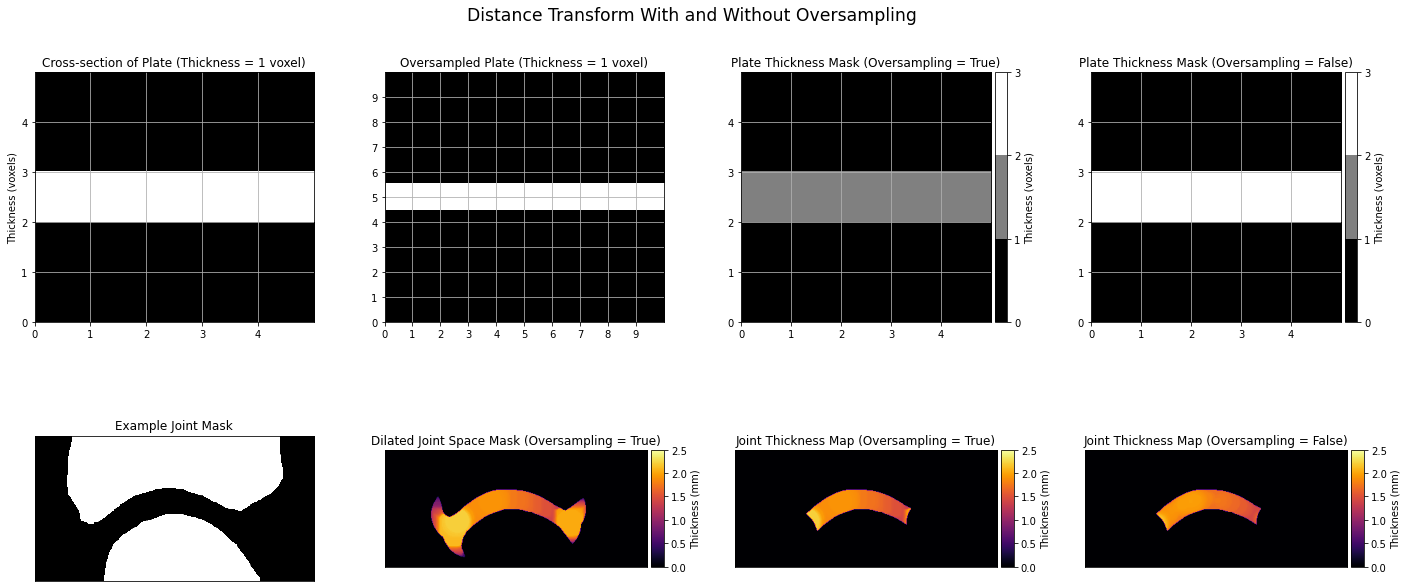

In [66]:
fig, axs = plt.subplots(figsize=(20,10), nrows=2, ncols=4)
fig.tight_layout(pad=4.0, rect=[0, 0.03, 1, 0.95])

fig.suptitle(
    "Distance Transform With and Without Oversampling",
    fontsize="xx-large")

# Create a custom colormap for the plate
# Thicknesses of 1 voxel = gray, thicknesses of 2 voxels = white
cmap = colors.ListedColormap(["black", "gray", "white"])
bounds=[0,1,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

ax1 = axs[0][0]
ax2 = axs[0][1]
ax3 = axs[0][2]
ax4 = axs[0][3]
ax5 = axs[1][0]
ax6 = axs[1][1]
ax7 = axs[1][2]
ax8 = axs[1][3]

# Plot the top row (plate images)
view_slice = (slice(None), mask.shape[1]//2, slice(None))
im1 = ax1.imshow(mask[view_slice], extent=[0, 5, 0, 5], cmap="gray", vmin=0, vmax=1, aspect="auto")
ax1.grid()
ax1.set_ylabel("Thickness (voxels)")
ax1.set_title("Cross-section of Plate (Thickness = 1 voxel)", wrap=True)
ax1.set_yticks(np.arange(0, 5, step=1))
ax1.set_xticks(np.arange(0, 5, step=1))

im2 = ax2.imshow(oversampled_mask[view_slice], extent=[0, 10, 0, 10], cmap="gray", vmin=0, vmax=0.5, aspect="auto")
ax2.grid()
ax2.set_title("Oversampled Plate (Thickness = 1 voxel)", wrap=True)
ax2.set_yticks(np.arange(0, 10, step=1))
ax2.set_xticks(np.arange(0, 10, step=1))

im3 = ax3.imshow(plate_oversample_mask[view_slice], extent=[0, 5, 0, 5], cmap=cmap, norm=norm, aspect="equal")
ax3.grid()
ax3.set_title("Plate Thickness Mask (Oversampling = True)", wrap=True)
ax3.set_yticks(np.arange(0, 5, step=1))
ax3.set_xticks(np.arange(0, 5, step=1))
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
cbar3 = plt.colorbar(im3, cax=cax3, label="Thickness (voxels)")

im4 = ax4.imshow(plate_no_oversample_mask[view_slice], extent=[0, 5, 0, 5], cmap=cmap, norm=norm, aspect="equal")
ax4.grid()
ax4.set_title("Plate Thickness Mask (Oversampling = False)", wrap=True)
ax4.set_yticks(np.arange(0, 5, step=1))
ax4.set_xticks(np.arange(0, 5, step=1))
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("right", size="5%", pad=0.05)
cbar4 = plt.colorbar(im4, cax=cax4, label="Thickness (voxels)")

# Plot the bottom row (joint images)
view_slice = (slice(None), local_thickness.shape[1]//2, slice(None))
im5 = ax5.imshow(arr[view_slice], cmap="gray", vmin=0, vmax=1, aspect="equal")
ax5.set_title("Example Joint Mask")
ax5.get_xaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)

im6 = ax6.imshow(dt_oversample[view_slice], cmap="inferno", vmin=0, vmax=2.5, aspect="equal")
ax6.set_title("Dilated Joint Space Mask (Oversampling = True)", wrap=True)
divider6 = make_axes_locatable(ax6)
cax6 = divider6.append_axes("right", size="5%", pad=0.05)
cbar6 = plt.colorbar(im6, cax=cax6, label="Thickness (mm)")
ax6.get_xaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)

im7 = ax7.imshow(dt_oversample_masked[view_slice], cmap="inferno", vmin=0, vmax=2.5, aspect="equal")
ax7.set_title("Joint Thickness Map (Oversampling = True)", wrap=True)
divider7 = make_axes_locatable(ax7)
cax7 = divider7.append_axes("right", size="5%", pad=0.05)
cbar7 = plt.colorbar(im7, cax=cax7, label="Thickness (mm)")
ax7.get_xaxis().set_visible(False)
ax7.get_yaxis().set_visible(False)

im8 = ax8.imshow(dt_no_oversample_masked[view_slice], cmap="inferno", vmin=0, vmax=2.5, aspect="equal")
ax8.set_title("Joint Thickness Map (Oversampling = False)", wrap=True)
divider8 = make_axes_locatable(ax8)
cax8 = divider8.append_axes("right", size="5%", pad=0.05)
cbar8 = plt.colorbar(im8, cax=cax8, label="Thickness (mm)")
ax8.get_xaxis().set_visible(False)
ax8.get_yaxis().set_visible(False)

plt.show()